In [1]:
import os
import pickle
from datetime import datetime, timezone
from scipy import stats
import pandas as pd
import matplotlib.colors
import matplotlib.cm as cm
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt

from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf
from wavespectra.input.swan import read_swans

%run -i wave_stats.py
%run -i spec_plot_funcs.py

#### Read SPOTTER data

In [2]:
DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP_Lee'
DATA_FILENAME = 'hurricane_lee_drifter_data_v1.pickle'
with open(os.path.join(DATA_DIRECTORY, DATA_FILENAME), 'rb') as handle:
    drifters = pickle.load(handle)
    
dirs1 = np.arange(0,365,10)
df2 = drifters['spotter']['SPOT-31232C']
df2 = df2.loc[df2.a1.dropna().index]
df2a = df2[df2.index == '2023-09-16 11:45']
f = df2a.frequency[0]
S = df2a.energy_density[0]
a1 = df2a.a1[0]
b1 = df2a.b1[0]
a2 = df2a.a2[0]
b2 = df2a.b2[0]

#### Read SWAN output

In [3]:
# SWAN output for several buoys at 9/16/2023 1200Z
swan_list = ['/proj/usgs-share/Projects/NOPP_forecast/Lee/dwsd630_2Dspec.txt',
'/proj/usgs-share/Projects/NOPP_forecast/Lee/n44098_2Dspec.txt',
'/proj/usgs-share/Projects/NOPP_forecast/Lee/s31232_2Dspec.txt',
'/proj/usgs-share/Projects/NOPP_forecast/Lee/sw065_2Dspec.txt']

# Read ASCII SWAN file and extract 2dspec for time index = tid
# uses wavespectra
df = read_swan( swan_list[2] ).isel(time=24)
fs = df['freq'].values
dirs = df['dir'].values

# dirs = -dirs+90
# dirs[dirs>=360]=dirs[dirs>=360]-360.
# dirs[dirs<0]=dirs[dirs<0]+360.
# # flip the directions, so now directions are where waves come from
dirs = dirs+180
dirs[dirs>=360.]=dirs[dirs>=360.]-360.

directional_bin_width_deg = dirs[2]-dirs[1]
print( directional_bin_width_deg )
dirs_r = (np.pi/180.)*dirs
efth = df.efth
print( np.size(f), np.size(dirs), np.size(efth) )
spec2d = np.squeeze( efth.values ) 

10.0
39 36 900


In [4]:
# Note that these dirs are not monotonic after flipping. Is that an issue?
dirs

array([185., 195., 205., 215., 225., 235., 245., 255., 265., 275., 285.,
       295., 305., 315., 325., 335., 345., 355.,   5.,  15.,  25.,  35.,
        45.,  55.,  65.,  75.,  85.,  95., 105., 115., 125., 135., 145.,
       155., 165., 175.])

#### Calculate Fourier coefs from SWAN 2dspec

In [5]:
# This routine is from Isabel
# Ss, a1s, a2s, b1s, b2s = to_Fourier( spec2d, fs, dirs_r, directional_bin_width_deg, faxis=0, daxis=1 )

# Because the conventions for a1, b1 are based on cartesian directions and the SWAN 2dspec is geographic,
# I think we should switch a1 and b1, and change the sign of a2.
Ss, b1s, a2s, a1s, b2s = to_Fourier( spec2d, fs, dirs_r, directional_bin_width_deg, faxis=0, daxis=1 )
a2s = -a2s

# Almost no energy in high frequencies, so truncate
igood = np.argwhere(Ss>1.e-8)
fs = np.squeeze(fs[igood])
Ss = np.squeeze(Ss[igood])
a1s = np.squeeze(a1s[igood])
a2s = np.squeeze(a2s[igood])
b1s = np.squeeze(b1s[igood])
b2s = np.squeeze(b2s[igood])

shape of Ef:  (25, 36)
shape of Ef:  (25,)


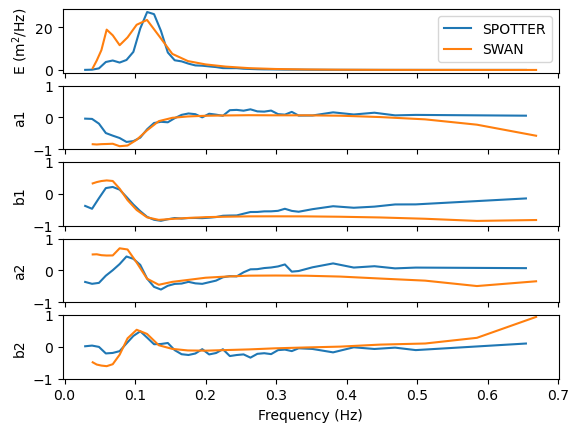

In [6]:
fig, ax = plt.subplots( 5, 1, sharex=True )
ax[0].plot(f, S, label='SPOTTER')
ax[0].plot(fs, Ss, label='SWAN')
ax[0].set_ylabel(r'E (m$^2$/Hz)')
ax[1].plot(f, a1)
ax[1].plot(fs, a1s)
ax[1].set_ylabel('a1')
ax[1].set_ylim(-1,1)
ax[2].plot(f, b1)
ax[2].plot(fs, b1s)
ax[2].set_ylabel('b1')
ax[2].set_ylim(-1,1)
ax[3].plot(f, a2)
ax[3].plot(fs, a2s)
ax[3].set_ylabel('a2')
ax[3].set_ylim(-1,1)
ax[4].plot(f, b2)
ax[4].plot(fs, b2s)
ax[4].set_ylabel('b2')
ax[4].set_ylim(-1,1)
ax[0].legend()
ax[4].set_xlabel('Frequency (Hz)')
plt.savefig('spotter31232_swan_a1b1.png', dpi=200, bbox_inches='tight')

#### Calculate the mean direction and directional spread at each frequency from the Fourier coefs. a1, b1, etc.

/vortexfs1/home/csherwood/src/NOPP_Utilities/wave_stats.py:216: RuntimeWarning: invalid value encountered in sqrt
  return (180./np.pi)* np.sqrt( 2. * (0.5 - np.sqrt( a2**2 + b2**2 ) ) )


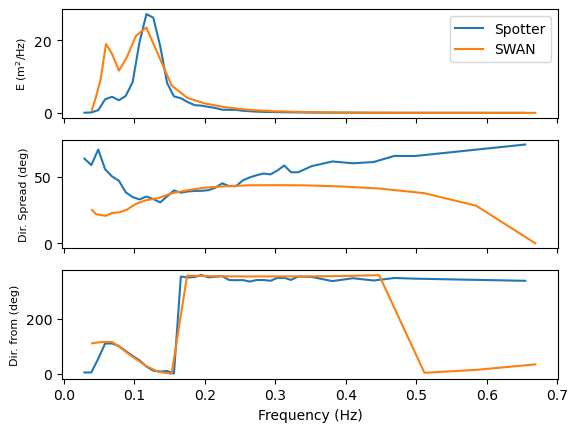

In [7]:
# statistics for Spotter
sprd1 = calc_spread1_a1b1( a1, b1 )
sprd2 = calc_spread2_a1b1( a2, b2 )
dm = calc_dirmf_a1b1( a1, b1)+180.
dm[dm>=360]=dm[dm>=360]-360.

# statistics for SWAN
sprd1s = calc_spread1_a1b1( a1s, b1s )
sprd2s = calc_spread2_a1b1( a2s, b2s )
dms = calc_dirmf_a1b1( a1s, b1s)+180

# don't know if this should happen now that a1, b1 have been switched
# # convert from math convention to geographic
# dms = -dms+90
# dms[dms>=360]=dms[dms>=360]-360.
# dms[dms<0]=dms[dms<0]+360.

# plot statistics
fig, ax = plt.subplots( 3, 1, sharex=True )
ax[0].plot(f, S, label='Spotter')
ax[0].plot(fs, Ss, label='SWAN' )
ax[0].set_ylabel(r'E (m$^2$/Hz)', fontsize=8)
ax[1].plot(f, sprd1)
ax[1].plot(fs, sprd1s)
ax[1].set_ylabel('Dir. Spread (deg)', fontsize=8)
ax[2].plot(f,dm)
ax[2].plot(fs,dms)
ax[2].set_ylabel('Dir. from (deg)', fontsize=8)
ax[2].set_xlabel('Frequency (Hz)')
ax[0].legend()
plt.savefig('spotter31232_swan_f_vs_dir.png', dpi=200, bbox_inches='tight')

#### Set up radial plot

In [8]:
%run -i spec_plot_funcs.py
# location of radial rings
radii_f=[0.05, 0.1, 0.2, 0.3, 0.4]

# placeholder in case we need to repostion the plot
x0 = 0.
y0 = 0.

#### Plot Spotter statistics

In [9]:
print(np.max(np.log10(S)))
print(np.min(np.log10(S)))

1.4360059535805862
-2.1709464528624713


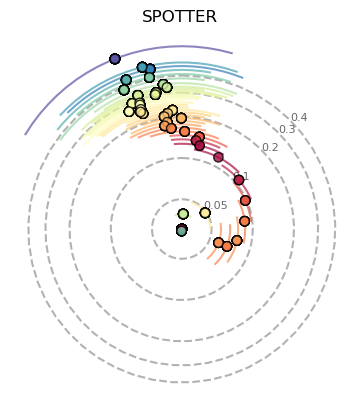

In [10]:
# TODO - move this into a function
fig = plt.figure( )
ax = fig.add_subplot()
ax.set_aspect('equal', adjustable='box')
# frequency rings
for fr in np.array( radii_f ):
    r = logr( fr )
    circle(ax, x0, y0, r, zorder=0)
# label rings
for i in np.array(radii_f):
    ptext(ax, x0, y0, logr(i), 45, "{}".format(i) )
ax.axis('off')

# for log scaling
vmin = -2.2
vmax = 1.5

# for linear scaling
# vmin=0.
# vmax=30.

cmap = cm.Spectral_r
plt_spread(ax, x0, y0, f, np.log10(S), dm, sprd1, sf=2., ps = 45, fc=1./33., 
           sfr=1., ec='black', vmin=vmin, vmax=vmax, cmap=cmap, rscale=False)
_ = plt.title('SPOTTER')
plt.savefig('spotter31232_radial_log.png', dpi=200, bbox_inches='tight')

#### Plot SWAN model results

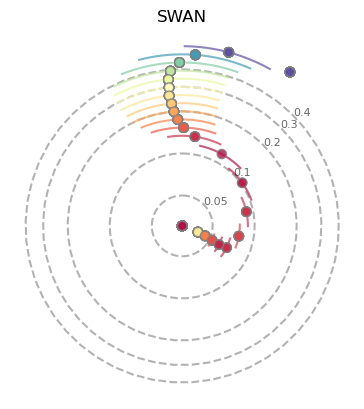

In [11]:
fig = plt.figure( )
ax = fig.add_subplot()
ax.set_aspect('equal', adjustable='box')
# frequency rings
for fr in np.array( radii_f ):
    r = logr( fr )
    circle(ax, x0, y0, r, zorder=0)
# label rings
for i in np.array(radii_f):
    ptext(ax, x0, y0, logr(i), 45, "{}".format(i) )
ax.axis('off')

cmap = cm.Spectral_r
plt_spread(ax, x0, y0, fs, np.log10(Ss), dms, sprd1s, sf=2., ps = 45, 
           vmin=vmin, vmax=vmax, fc=1./33., sfr=1., ec='gray', cmap=cmap, rscale=False)
_ = plt.title('SWAN')
plt.savefig('swan_radial.png', dpi=200, bbox_inches='tight')

#### Try observations (gray) and model (red) on same plot

AttributeError: 'Axes' object has no attribute 'colorbar'

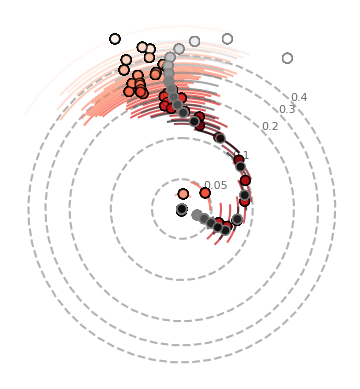

In [14]:
fig = plt.figure( )
ax = fig.add_subplot()
ax.set_aspect('equal', adjustable='box')
# frequency rings
for fr in np.array( radii_f ):
    r = logr( fr )
    circle(ax, x0, y0, r, zorder=0)
# label rings
for i in np.array(radii_f):
    ptext(ax, x0, y0, logr(i), 45, "{}".format(i) )
ax.axis('off')

# plot Spotter data with grayscale
cmap = cm.Reds
#cmap = cm.Spectral_r

plt_spread(ax, x0, y0, f, np.log10(S), dm, sprd1, sf=2., vmin=vmin, vmax=vmax, 
           ps = 45, fc=1./33., sfr=1., ec='black', cmap=cmap, rscale=False)

# plot SWAN data with red
cmap = cm.Greys
#cmap = cm.Spectral_r

plt_spread(ax, x0, y0, fs, np.log10(Ss), dms, sprd1s, sf=2., vmin=vmin, vmax=vmax, 
           ps = 45, fc=1./33., sfr=1., ec='gray', cmap=cmap, rscale=False)

_ = plt.title('SPOTTER (red) SWAN (gray)')
plt.savefig('spotter31232_swan_radial.png', dpi=200, bbox_inches='tight')